# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

![](https://s3.amazonaws.com/dq-content/288/s1gp_fdg_stars.png)

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded **up** to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

![](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png)

The two distributions above are displayed using a simple line plot, which is also a valid way to show the shape of a distribution. The variable being examined is *movie rating*, and for each unique rating we can see its relative frequency (percentage) on the y-axis of the graph. When an analysis report is intended for large audiences, relative frequencies (especially percentages) are preferred over absolute frequencies.

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of *displayed ratings* is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the Data

One of the best ways to figure out whether there has been any change in Fandango's rating system after Hickey's analysis is to compare the system's characteristics previous and after the analysis. Fortunately, we have ready-made data for both these periods of time:

- Walt Hickey made the data he analyzed publicly available [on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system *previous* to his analysis.
- One *user* collected movie ratings data for movies released in 2016 and 2017. The data is publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics *after* Hickey's analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('fandango_score_comparison.csv') as f:
    previous = pd.read_csv(f)
    
previous.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [4]:
previous.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,...,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,6.736986,4.089041,3.845205,3.042466,3.193836,2.940411,...,3.368493,3.065068,3.226027,2.972603,3.270548,3.380137,185.705479,42846.205479,3848.787671,0.243836
std,30.168799,20.024430,19.517389,1.510712,0.958736,0.540386,0.502831,1.508440,1.001222,0.975869,...,0.479368,1.514600,1.007014,0.990961,0.788116,0.502767,316.606515,67406.509171,6357.778617,0.152665
min,5.000000,20.000000,13.000000,2.400000,4.000000,3.000000,2.700000,0.250000,1.000000,0.650000,...,2.000000,0.500000,1.000000,0.500000,1.000000,2.000000,4.000000,243.000000,35.000000,0.000000
25%,31.250000,50.000000,43.500000,5.700000,6.300000,3.500000,3.500000,1.562500,2.500000,2.175000,...,3.150000,1.500000,2.500000,2.125000,3.000000,3.000000,33.250000,5627.000000,222.250000,0.100000
50%,63.500000,66.500000,59.000000,6.850000,6.900000,4.000000,3.900000,3.175000,3.325000,2.950000,...,3.450000,3.000000,3.500000,3.000000,3.500000,3.500000,72.500000,19103.000000,1446.000000,0.200000
75%,89.000000,81.000000,75.000000,7.500000,7.400000,4.500000,4.200000,4.450000,4.050000,3.750000,...,3.700000,4.500000,4.000000,4.000000,4.000000,3.500000,168.500000,45185.750000,4439.500000,0.400000
max,100.000000,94.000000,94.000000,9.600000,8.600000,5.000000,4.800000,5.000000,4.700000,4.700000,...,4.300000,5.000000,4.500000,4.500000,5.000000,4.500000,2375.000000,334164.000000,34846.000000,0.500000


In [5]:
with open('movie_ratings_16_17.csv') as f:
    after = pd.read_csv(f)
    
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [6]:
after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


In [7]:
after.describe()

,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2016.107477,53.266355,6.440654,53.621495,58.626168,3.894860,2.663318,3.220327,2.681075,2.931308,2.658879,3.214953,2.691589,2.915888
std,0.310444,17.843585,1.030056,30.242396,21.100040,0.516781,0.892179,0.515028,1.512120,1.055002,0.924619,0.526803,1.519273,1.060352
min,2016.000000,11.000000,3.500000,0.000000,11.000000,2.500000,0.550000,1.750000,0.000000,0.550000,0.500000,2.000000,0.000000,0.500000
25%,2016.000000,39.000000,5.825000,27.000000,43.250000,3.500000,1.950000,2.912500,1.350000,2.162500,2.000000,3.000000,1.500000,2.000000
50%,2016.000000,53.500000,6.500000,56.500000,60.500000,4.000000,2.675000,3.250000,2.825000,3.025000,2.500000,3.000000,3.000000,3.000000
75%,2016.000000,66.000000,7.200000,83.000000,76.750000,4.500000,3.300000,3.600000,4.150000,3.837500,3.500000,3.500000,4.000000,4.000000
max,2017.000000,99.000000,8.500000,99.000000,93.000000,5.000000,4.950000,4.250000,4.950000,4.650000,5.000000,4.000000,5.000000,4.500000


We isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use.

+ For the data set with ratings previous to Hickey's analysis, we select the following columns: `'FILM'`, `'Fandango_Stars'`, `'Fandango_Ratingvalue'`, `'Fandango_votes'`, `'Fandango_Difference'`.
+ For the other data set, we select the the following columns: `'movie'`, `'year'`, `'fandango'`.

In [9]:
fandango_previous = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]

fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [10]:
fandango_after = after[['movie', 'year', 'fandango']]

fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


By reading the `README.md` files of the two repositories, we concluded that the sampling processes were not random, and the resulting samples are very unlikely to be representative of the population we're interested in describing.

## Changing the Goal of our Analysis

At this point, we have at least two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations on it.

Tweaking our goal seems a much faster choice compared to collecting new data. Also, it's quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time.

Our new goals is *to finding out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.*

With the new goal, we now have two populations that we want to describe and compare with each other:

+ All Fandango's ratings for popular movies released in 2015.
+ All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [12]:
fandango_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


After we checked on the website, we concluded that the sample is representive.

Let's also double-check the other data set for popular movies. The documentation states clearly that there're only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [13]:
(fandango_previous['Fandango_votes'] < 30).sum()

0

If we explore the data sets enough, we'll notice that some movies were not released in 2015 and 2016. We need to isolate only the sample points that belong to our populations of interest.

+ We isolate the movies released in 2015 in a separate data set.

In [14]:
fandango_previous.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [15]:
fandango_previous['Year'] = fandango_previous['FILM'].str[-5:-1]

fandango_previous['Year'].value_counts()

C:\Users\Utente\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2015    129
2014     17
Name: Year, dtype: int64

In [16]:
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()

fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

In [17]:
fandango_after.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


In [18]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [19]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()

fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

These are the data sets we'll use next to perform our analysis.

## Comparing Distributions Shapes for 2015 and 2016

After all these preliminary steps, we can now start analyzing the two samples we isolated before. Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

There are many ways we can go about with our analysis, but let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

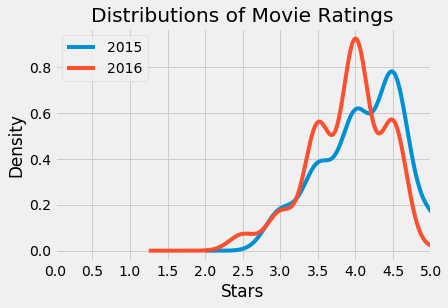

In [20]:
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label='2015', legend=True)
fandango_2016['fandango'].plot.kde(label='2016', legend=True)
plt.xlabel('Stars')
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.title('Distributions of Movie Ratings')
plt.show()

## Comparing Relative Frequencies
​
The kernel density plots showed that there's a clear difference between the two distributions. They also provided us with information about the direction of the difference: movies in 2016 were rated slightly lower than those in 2015.
​
While comparing the distributions with the help of the kernel density plots was a great start, we now need to analyze more granular information.

In [21]:
(fandango_2015['Fandango_Stars'].value_counts(normalize=True)*100).sort_index()

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [22]:
(fandango_2016['fandango'].value_counts(normalize=True)*100).sort_index()

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

## Determine the Direction of the Change

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

We'll take a couple of summary statistics to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [24]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


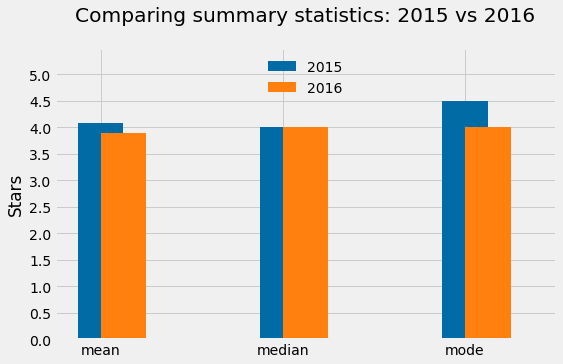

In [25]:
summary['2015'].plot.bar(color = (0/255, 107/255, 164/255), align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = (255/255, 128/255, 14/255), align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.